In [1]:
#puts above directory into the path
import sys
sys.path.append("../../VREP_robot")
sys.path.append("../../VREP_robot/utils")
sys.path.append("../")
import vrep
from vrepRobot import *

from forwardKinematics import robot_config
import numpy as np
import time

pi = np.pi

In [2]:
# myRobot = robot_config()
# vrep_env = VREP_Environement()
# robot_handles  = ['pose_j0', 'pose_j1', 'pose_j2', 'pose_j3', 'pose_j4', 'pose_j5', 'pose_j6', 'pose_j7']
# vrep_env.add_robot(VREP_Robot('robot', robot_handles))
# vrep_env.start_simulation()

In [3]:
# setup environment
myRobot = robot_config()
# vrep_env = VREP_Environement(synchronous=False)
vrep_env = VREP_Environement(synchronous=True)
ik_handles = ['ik_joint1', 'ik_joint2', 'ik_joint3', 'ik_joint4', 'ik_joint5', 'ik_joint6', 'ik_joint7', 'ik_ee', 'kinematicsTest_IKTip', 'ik_rf7_static']
vrep_env.add_robot(VREP_Robot('ik_robot', ik_handles, connection_type = 'nonblocking'))
vrep_env.start_simulation()

Connected to remote API server
In synchronous mode
1 robot(s) connected: ['ik_robot']


In [4]:
# start = time.time()

# while time.time() - start < 18:
#     dt = time.time() - start
#     a = np.sin(dt)*0.5
#     q = np.array([0.2, -2.5, 0., 0., 0., 0., 0. + a])
#     positions = np.zeros((8,3))
#     positions[1:,:] = (myRobot.forwardKinPos(q))
#     orientations = np.zeros((8, 4)) #4 for quat
#     orientations[0,-1] = 1

#     print('Forward kinematic positions: {}'.format(positions))
#     orientations[1:,:] = myRobot.forwardKinOrientation(q)
#     print('Forward kinematic orientations: {}'.format(orientations))

#     print(vrep_env.robot.handle_names)
#     for i in range(len(robot_handles)):
#         vrep_env.robot.setObjectPosition(vrep_env.robot.handles[i], positions[i])
#         vrep_env.robot.setObjectQuaternion(vrep_env.robot.handles[i], orientations[i])
        
#     time.sleep(0.2)

In [5]:
#JEE = myRobot.J('EE', q)
#print("analytic jacobian: \n{}".format(JEE))

In [6]:
vrep_env.ik_robot.getCollisionHandle('Collision')
time.sleep(1)

In [9]:
# initialize collision check
# !!!important
vrep_env.ik_robot.getCollisionState(initialize=True)
vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)

(0, [-4.470348358154297e-08, 0.0, 2.9802322387695312e-08, 1.0])

In [10]:
# generate config samples
from configGenerator_VREP import configGenerator_VREP
config = configGenerator_VREP.generate_sample(5)  # !!!set sample number here
total_config = config.shape[0]
print("total configs = ", total_config)
print(config)
print(total_config/50/3600)

total configs =  15625
[[-5.000e-02 -2.250e-02 -4.500e+01 -2.600e+01 -2.510e+01 -2.600e+01]
 [-5.000e-02 -2.250e-02 -4.500e+01 -2.600e+01 -2.510e+01 -1.300e+01]
 [-5.000e-02 -2.250e-02 -4.500e+01 -2.600e+01 -2.510e+01  0.000e+00]
 ...
 [ 5.000e-02  4.525e-01  4.500e+01  2.600e+01  2.590e+01  0.000e+00]
 [ 5.000e-02  4.525e-01  4.500e+01  2.600e+01  2.590e+01  1.300e+01]
 [ 5.000e-02  4.525e-01  4.500e+01  2.600e+01  2.590e+01  2.600e+01]]
0.08680555555555555


In [11]:
# initialize collision state placeholder
y = np.zeros((total_config))
EEPosition = np.zeros((total_config,3))
EEOrientation = np.zeros((total_config,3))
EEQuaternion = np.zeros((total_config,4))

In [12]:
# collision detect
from tqdm import tqdm_notebook as tqdm

pbar = tqdm(total=total_config)  # set progress bar

t = time.clock()
for i in range(total_config):
#for i in range(len(jointAngle)):
    joint_angle = config[i, :]
    for j in range(6):
        vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[j], joint_angle[j])
    #vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[5], jointAngle[i])
    
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    #vrep.simxGetPingTime(vrep_env.clientID)
    #time.sleep(1)
    collisionState = vrep_env.ik_robot.getCollisionState()
    #print(collisionState)
    y[i] = collisionState
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    #vrep.simxGetPingTime(vrep_env.clientID)
    EEPosition[i,:] = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    EEOrientation[i,:] = vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    EEQuaternion[i,:] = vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    pbar.update(1)
#     time.sleep(0.5)
    #print(EEPosition[i,:])
    
    if i%int(total_config/100+1) == 0:
        Data = np.hstack((config, y.reshape(-1,1),EEPosition,EEOrientation,EEQuaternion))
        #np.save(r'C:\Users\xumw1\Documents\GitHub\robotPathPlanning\logs\CollisionData{}.npy'.format(i),Data)
        np.save('logs/CollisionData{}.npy'.format(i),Data)
    
pbar.close()
print('runtime = ', time.clock()-t)  
print('collision state = ', y)
print('EEPosition\n', EEPosition)
print('EEPrientation\n', EEOrientation)
print('EEQuaternion\n', EEQuaternion)
#np.save(r'C:\Users\xumw1\Documents\GitHub\robotPathPlanning\logs\CollisionData.npy',Data)
np.save('logs/CollisionData.npy',Data)


runtime =  421.64784450710994
collision state =  [0. 0. 0. ... 0. 1. 1.]
EEPosition
 [[ 4.76837158e-07  4.99997139e-02 -2.98023224e-07]
 [ 4.76837158e-07  4.99997139e-02 -2.98023224e-07]
 [-1.04520559e-01  2.92974234e-01 -3.64218950e-01]
 ...
 [-1.81199431e-01  1.17464751e-01  2.78979123e-01]
 [-1.42311692e-01  1.85368985e-01  1.42360091e-01]
 [-1.42311692e-01  1.85368985e-01  1.42360091e-01]]
EEPrientation
 [[-8.94069672e-08 -2.66453526e-15  5.96046448e-08]
 [-8.94069672e-08 -2.66453526e-15  5.96046448e-08]
 [-2.01463223e+00 -4.92695898e-01 -2.32834673e+00]
 ...
 [-9.07571912e-01 -9.04081047e-01  1.57079637e+00]
 [-2.02828860e+00 -5.05016685e-01  7.84706831e-01]
 [-2.02828860e+00 -5.05016685e-01  7.84706831e-01]]
EEQuaternion
 [[-4.47034836e-08  0.00000000e+00  2.98023224e-08  1.00000000e+00]
 [-4.47034836e-08  0.00000000e+00  2.98023224e-08  1.00000000e+00]
 [-2.04635382e-01 -8.04544091e-01 -3.94229203e-01  3.94229084e-01]
 ...
 [-5.56447327e-01  1.23414386e-03  7.07105696e-01  4.36

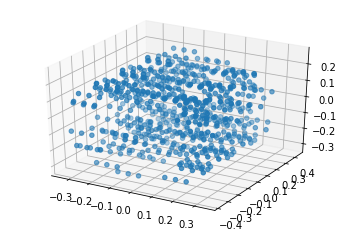

In [29]:
# plot
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition[:,1], EEPosition[:,2], -EEPosition[:,0])
plt.show()

In [30]:
EEPosition_free = EEPosition[y==0,:]
print(EEPosition_free)

[[-1.04520559e-01  2.92974234e-01 -3.64218950e-01]
 [ 9.41690803e-02  3.27101260e-01 -3.37556064e-01]
 [ 1.28170013e-01  3.09813589e-01 -1.84804469e-01]
 [ 1.08899832e-01  1.81878537e-01 -9.50866938e-02]
 [ 1.60609722e-01  2.85150498e-01 -3.70331526e-01]
 [ 2.29224980e-01  2.47039407e-01 -2.33849049e-01]
 [ 1.90337181e-01  1.30906105e-01 -1.34910733e-01]
 [-1.04520679e-01  2.01007605e-01 -1.68151438e-01]
 [-1.71601653e-01  6.99945688e-02 -1.12261772e-01]
 [ 9.41689014e-02  2.01007724e-01 -1.24843836e-01]
 [ 1.28170192e-01  6.99944794e-02 -4.44233716e-02]
 [ 1.60609603e-01  2.01007664e-01 -1.78080022e-01]
 [ 2.29225099e-01  6.99945390e-02 -1.24085069e-01]
 [-1.71601653e-01 -1.34817511e-01 -1.88741833e-01]
 [ 1.28170311e-01 -1.88274533e-01 -1.46976382e-01]
 [ 1.08900011e-01 -2.44377106e-01 -2.92815745e-01]
 [ 1.60609722e-01 -2.29194760e-03 -1.26023769e-01]
 [ 1.90337241e-01 -1.93404526e-01 -3.32639754e-01]
 [-2.22979426e-01 -8.25509727e-02 -3.64218682e-01]
 [-2.57106304e-01  1.16138607e-

 [-1.81199431e-01  1.17464751e-01  2.78979123e-01]]


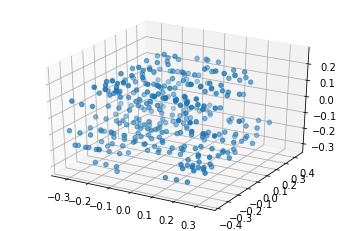

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition_free[:,1], EEPosition_free[:,2], -EEPosition_free[:,0])
plt.show()

In [32]:
#test
EEPosition = np.zeros((5,3))
joint_angle = np.linspace(0,1,5)
for i in range(5):
    vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[0], joint_angle[i])
    vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[1], joint_angle[i])
    vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[3], joint_angle[i])
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    vrep.simxGetPingTime(vrep_env.clientID)
    collisionState = vrep_env.ik_robot.getCollisionState()
    EEPosition[i,:] = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    time.sleep(1)
    print(collisionState)
print('EEPosition\n', EEPosition)

False
True
True
True
True
EEPosition
 [[-0.14231169  0.12143329 -0.13218689]
 [-0.14231157 -0.03155687  0.08037645]
 [-0.14231145  0.00473002  0.28247321]
 [-0.14231133  0.02803704  0.47708142]
 [-0.14231157  0.03536907  0.68985993]]


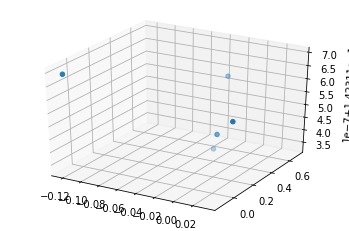

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition[:,1], EEPosition[:,2], -EEPosition[:,0])
plt.show()